# EDA

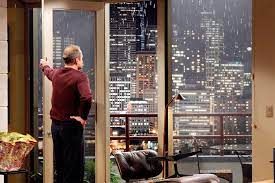

In [1669]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [1670]:

# as column 'condition' is truncated in the display, disable column truncation
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', -1)

#### Client:
* Erin Robinson
* Socially responsible -> will buy cheap houses, renovate and sell with costs back and small profit.
<br>

#### Hypotheses: 
* Homes that are further away of a city center or in a rural area are cheaper. --> Buy cheap.
* Buying big houses with few rooms and renovating them to have enough rooms for a family is socially responsible.
 --> Socially responsible.
 --> built hypothesis all around renovation, nr rooms having an effect on price 
* Homes in a neighbourhood of people with a migration background are cheaper. 


<br>

In [1671]:
df = pd.read_csv('./data/King_County_House_prices_dataset.csv')

In [1672]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,17755.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,83.637,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,399.946,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


In [1673]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [1674]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1675]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [1676]:
# check how many duplicated rows exist in the data frame
df.duplicated().value_counts()
# no duplicates

False    21597
dtype: int64

In [1677]:
# Drop the ID column: won't need it for merging
df = df.drop('id', axis=1)

In [1678]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [1679]:
# Top ten cities in King County by Total Population by Place
# Source: https://statisticalatlas.com/county/Washington/King-County/Population
# Definition city center: lat and long of city town/city hall

cities = {
    'Seattle':  (47.5994862,-122.3386744),
    'Bellvue': (47.614463,-122.2310811),
    'Kent': (47.3806225,-122.2561947,),
    'Renton': (47.4747632,-122.2142851),
    'Federal Way': (47.3012382,-122.322559),
    'Kirkland': (47.678471,-122.2452861),
    'Auburn': (47.3078503,-122.2484648),
    'Sammamish': (47.601572,-122.0390594),
    'Redmond': (47.6789194,-122.1358138),
    'Shoreline': (47.7562273,-122.3463749)

}


# Calculate distance from house to next city center: ((house.lat - center.lat) + (house.long - center.long)**2)**0.5
# 1 degree = 111km
def distance(lat: float, long: float, center: tuple[float, float]) -> float:
    return round((((lat - center[0])**2 + (long - center[1])**2)**0.5)*111, 3)


# Returns distance to center of nearest city in km:
def distance_to_center(lat: float, long: float) -> tuple:
    distances = {cityname: distance(lat, long, center) for cityname, center in cities.items()}
    smallest_distance = min(distances.items(), key=lambda x: x[1])
    return smallest_distance

In [1680]:
# Create new column: 'city'
df['city'] = df.apply(lambda x: distance_to_center(x['lat'], x['long'])[0], axis=1)
df.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650,Renton
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639,Shoreline
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062,Kirkland
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000,Seattle
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503,Sammamish


In [1681]:
df['distance_to_center'] = df.apply(lambda x: distance_to_center(x['lat'], x['long'])[1], axis=1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,distance_to_center
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650,Renton,6.232
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639,Shoreline,4.952
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062,Kirkland,6.736
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000,Seattle,10.614
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503,Sammamish,1.814


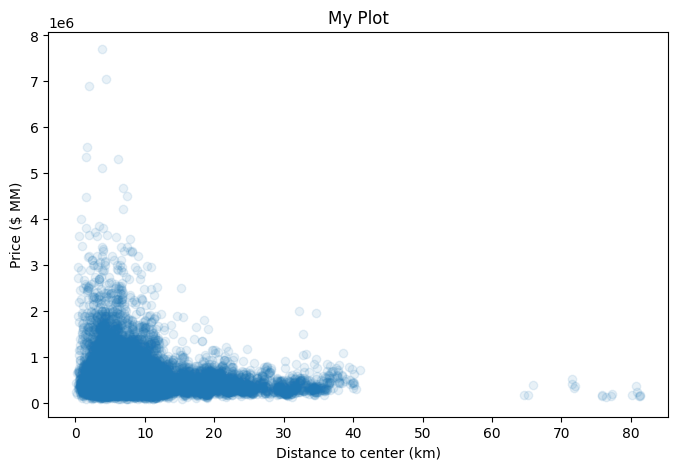

In [1682]:
plt.scatter(df['distance_to_center'], df['price'], alpha=0.1)

plt.xlabel('Distance to center (km)')
plt.ylabel('Price ($ MM)')
plt.title('My Plot')

plt.show();


In [1683]:
# make plot with grade and distance

#df.plot(kind='scatter', x='distance_to_center', y='grade', alpha=0.5)

# grade is not affected by distance

In [1684]:
#df.plot(kind='scatter', x='grade', y='price', alpha=0.5)

In [1685]:
# scatterplot city nach price

#df.plot(kind='scatter', x='city', y='price', alpha=0.5)

In [1686]:
# Categories (4, interval[float64, right]): 
# [0, 10, 20, 30, 40] --> ['center', 'near center', 'suburbs', 'rural']

distance_rating_bins = pd.cut(df['distance_to_center'], [0, 10, 20, 30, 40], labels=['center', 'near center', 'suburbs', 'rural']) #, labels=['center', 'near center', 'suburbs', 'outer area', 'rural'])
distance_rating_bins.name = 'distance_rating'

df = df.join(distance_rating_bins, how='inner')
df.head(10)
# print(distance_rating_bins)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,distance_to_center,distance_rating
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650,Renton,6.232,center
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639,Shoreline,4.952,center
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062,Kirkland,6.736,center
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000,Seattle,10.614,near center
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503,Sammamish,1.814,center
5,5/12/2014,1230000.000,4,4.500,5420,101930,1.000,0.000,0.000,3,11,3890,1530.0,2001,0.000,98053,47.656,-122.005,4760,101930,Sammamish,7.136,center
6,6/27/2014,257500.000,3,2.250,1715,6819,2.000,0.000,0.000,3,7,1715,?,1995,0.000,98003,47.310,-122.327,2238,6819,Federal Way,1.061,center
7,1/15/2015,291850.000,3,1.500,1060,9711,1.000,0.000,NaN,3,7,1060,0.0,1963,0.000,98198,47.410,-122.315,1650,9711,Kent,7.272,center
8,4/15/2015,229500.000,3,1.000,1780,7470,1.000,0.000,0.000,3,7,1050,730.0,1960,0.000,98146,47.512,-122.337,1780,8113,Seattle,9.679,center
9,3/12/2015,323000.000,3,2.500,1890,6560,2.000,0.000,0.000,3,7,1890,0.0,2003,0.000,98038,47.368,-122.031,2390,7570,Renton,23.522,suburbs


In [1687]:
# for query in next two plots calculate price per sqft_living per house:
price_per_sqft_series= df['price']/df['sqft_living']
price_per_sqft_series.name = 'price_per_sqft'
df = pd.concat([df, price_per_sqft_series], axis=1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,distance_to_center,distance_rating,price_per_sqft
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650,Renton,6.232,center,188.051
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639,Shoreline,4.952,center,209.339
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062,Kirkland,6.736,center,233.766
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000,Seattle,10.614,near center,308.163
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503,Sammamish,1.814,center,303.571


In [1688]:
# for query in next two plots calculate price per sqft_lot per house
price_per_sqft_lot_series= df['price']/df['sqft_lot']
price_per_sqft_lot_series.name = 'price_per_sqft_lot'
df = pd.concat([df, price_per_sqft_lot_series], axis=1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,distance_to_center,distance_rating,price_per_sqft,price_per_sqft_lot
0,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650,Renton,6.232,center,188.051,39.274
1,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639,Shoreline,4.952,center,209.339,74.289
2,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062,Kirkland,6.736,center,233.766,18.000
3,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000,Seattle,10.614,near center,308.163,120.800
4,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503,Sammamish,1.814,center,303.571,63.119


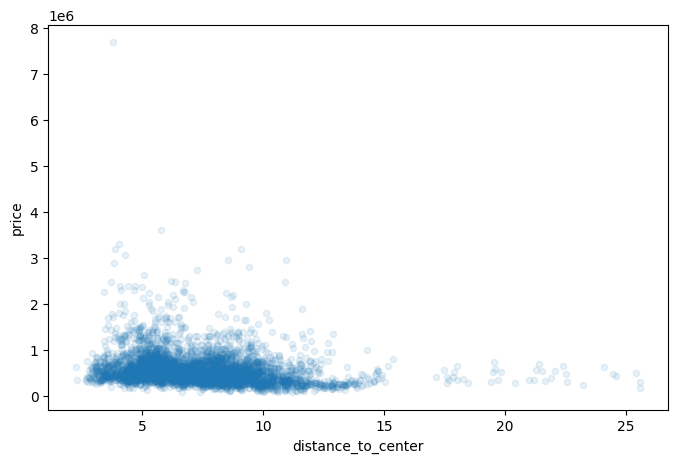

In [1689]:
df.query('city == "Seattle"').plot(kind='scatter', x='distance_to_center', y='price', alpha=0.1);
# add subplots where y= price_per_sqft and y= price_per_sqft_lot

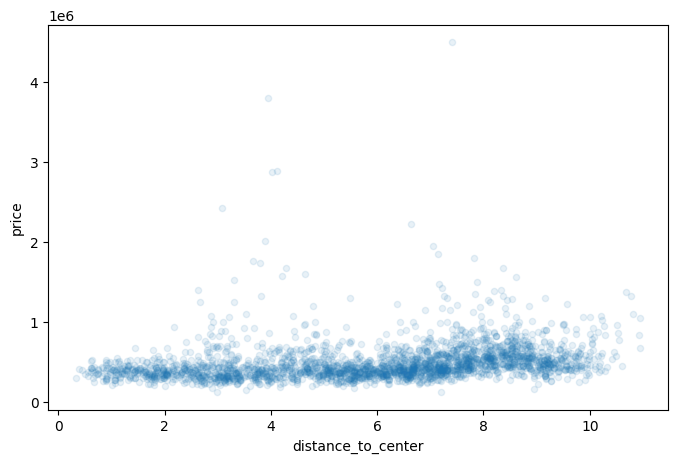

In [1690]:
df.query('city == "Shoreline"').plot(kind='scatter', x='distance_to_center', y='price', alpha=0.1);
# add subplots where y= price_per_sqft and y= price_per_sqft_lot